## Importing all the necessary dependencies

In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.optimizers import Adam

## Loading the dataset

In [2]:
language_dataset = pd.read_csv('dataset.csv')

In [3]:
language_dataset.sample(5)

,Text,language
11072,短期留学生用の学生寮が「衣笠キャンパス」近くに棟ある。主に中長期留学生用の学生寮が「びわこく...,Japanese
10910,în fiecare dimineață începând cu ora și indif...,Romanian
4074,em três enquetes realizadas pela revista placa...,Portugese
6614,la sfârșitul secolului al xix-lea făcea parte ...,Romanian
12073,複数の航空会社の民間航空機生産部門を再編して年月日に中国上海で設立された。資本金は億元（年月...,Japanese


In [4]:
language_dataset.isnull().sum()

Text        0
language    0
dtype: int64

In [5]:
language_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      22000 non-null  object
 1   language  22000 non-null  object
dtypes: object(2)
memory usage: 343.9+ KB


In [6]:
language_dataset['language'].value_counts()

language
Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: count, dtype: int64

## Checking for duplicate values in the dataset

In [7]:
language_dataset.duplicated().sum()

141

## Dropping the duplicate values from the dataset

In [8]:
language_dataset.drop_duplicates(inplace=True)

## Confirming whether the duplicate values are deleted from the dataset or not

In [9]:
language_dataset.duplicated().sum()

0

## Encoding the labels

In [10]:
encoder = LabelEncoder()

language_dataset['language_encoded'] = encoder.fit_transform(language_dataset['language'])

In [11]:
language_dataset.sample(5)

,Text,language,language_encoded
13050,الحباشي أولاد الحبيشي العمارنة وهم من أصل ...,Arabic,0
4806,بايد په ياد ولرو چه سترپتوماسين دنورو انتى بيو...,Pushto,13
6371,omni deglaciationi pagocalymmatum recessus et ...,Latin,10
18994,o râguebi foi apresentado aos francesas na cid...,Portugese,12
6560,年月日，格林決定加入密西根州立大學（ michigan state university ）...,Chinese,1


## Identifying which integer is assigned to which label

In [12]:
language_label_identify_unique = language_dataset[['language', 'language_encoded']].drop_duplicates().sort_values(by='language_encoded')

In [13]:
language_label_identify_unique

,language,language_encoded
46,Arabic,0
13,Chinese,1
4,Dutch,2
37,English,3
0,Estonian,4
12,French,5
19,Hindi,6
10,Indonesian,7
5,Japanese,8
14,Korean,9


## Separating features and labels

In [14]:
X = language_dataset['Text']
y = language_dataset['language_encoded']

## Performing train test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing the data

In [16]:
y_train = to_categorical(y_train, num_classes=22)
y_test = to_categorical(y_test, num_classes=22)

In [17]:
word_tokenizer = Tokenizer()

In [18]:
word_tokenizer.fit_on_texts(X_train)

In [19]:
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [20]:
vocab_length = len(word_tokenizer.word_index) + 1

In [21]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
embedding_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding='utf8')


for line in glove_file:
    records = line.split()
    word = records[0]
    corresponding_vector_of_the_word = np.asarray(records[1:], dtype='float32')
    embedding_dictionary[word] = corresponding_vector_of_the_word

glove_file.close()

In [23]:
embedding_matrix = np.zeros((vocab_length, 100))


for word, index in word_tokenizer.word_index.items():
    
    getting_corresponding_word_from_embedding_vector = embedding_dictionary.get(word)
    
    if getting_corresponding_word_from_embedding_vector is not None:
        
        embedding_matrix[index] = getting_corresponding_word_from_embedding_vector

In [24]:
embedding_matrix.shape

(234753, 100)

## Creating the embedding layer

In [25]:
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

## Defining the early stop

In [26]:
early_stop_loss = EarlyStopping(monitor='loss', patience=2)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2)

## Creating and training the model

In [27]:
model = Sequential()

In [28]:
model.add(embedding_layer)

model.add(Flatten())

model.add(Dense(128, activation='tanh'))

model.add(Dense(64, activation='tanh'))

model.add(Dense(32, activation='tanh'))

model.add(Dense(22, activation='softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          23475300  
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 128)               1280128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 22)                726       
                                                                 
Total params: 24,766,490
Trainable params: 1,291,190
Non

In [30]:
model.compile(optimizer=Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.fit(x=X_train, y=y_train, validation_data=[X_test, y_test], batch_size=64, epochs=100, callbacks=[early_stop_loss, early_stop_val_loss])

Epoch 1/100
274/274 [==============================] - 5s 7ms/step - loss: 2.7109 - accuracy: 0.2613 - val_loss: 2.4866 - val_accuracy: 0.3994
Epoch 2/100
274/274 [==============================] - 2s 6ms/step - loss: 2.3123 - accuracy: 0.4770 - val_loss: 2.2201 - val_accuracy: 0.5050
Epoch 3/100
274/274 [==============================] - 2s 6ms/step - loss: 2.0734 - accuracy: 0.5530 - val_loss: 2.0297 - val_accuracy: 0.5503
Epoch 4/100
274/274 [==============================] - 2s 6ms/step - loss: 1.8919 - accuracy: 0.5951 - val_loss: 1.8807 - val_accuracy: 0.5814
Epoch 5/100
274/274 [==============================] - 2s 6ms/step - loss: 1.7466 - accuracy: 0.6293 - val_loss: 1.7597 - val_accuracy: 0.6098
Epoch 6/100
274/274 [==============================] - 2s 6ms/step - loss: 1.6255 - accuracy: 0.6550 - val_loss: 1.6576 - val_accuracy: 0.6297
Epoch 7/100
274/274 [==============================] - 2s 7ms/step - loss: 1.5209 - accuracy: 0.6718 - val_loss: 1.5692 - val_accuracy: 0.6452

## Plotting loss VS val_loss and accuracy VS val_accuracy graph

In [32]:
history = pd.DataFrame(model.history.history)

<Axes: >

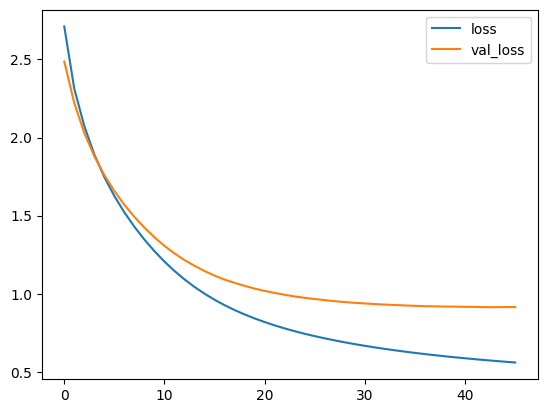

In [33]:
history[['loss', 'val_loss']].plot()

<Axes: >

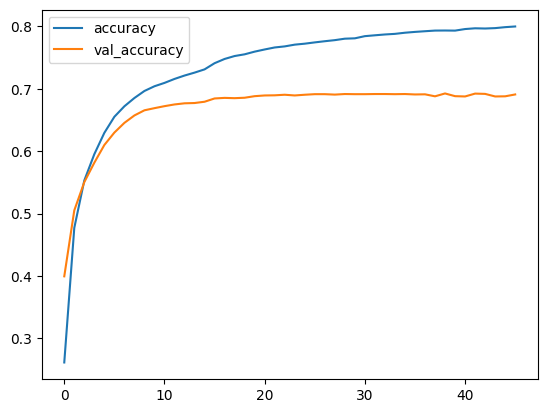

In [34]:
history[['accuracy', 'val_accuracy']].plot()

## Evaluating the model on training and testing data

In [35]:
model.evaluate(X_train, y_train)[1]

547/547 [==============================] - 3s 5ms/step - loss: 0.5550 - accuracy: 0.8012


0.8012237548828125

In [36]:
model.evaluate(X_test, y_test)[1]

137/137 [==============================] - 1s 5ms/step - loss: 0.9146 - accuracy: 0.6908


0.6907593607902527

## Performing prediction on sample data

In [37]:
sample_data = "klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemÃ¤rke  aastal viidi ta surnukeha mausoleumist Ã¤ra ja kremeeriti zlÃ­ni linn kandis aastatel â€“ nime gottwaldov ukrainas harkivi oblastis kandis zmiivi linn aastatel â€“ nime gotvald"

In [38]:
sample_data_sequence = word_tokenizer.texts_to_sequences([sample_data])

In [39]:
sample_data_padded = pad_sequences(sample_data_sequence, padding='post', maxlen=100)

In [40]:
prediction = model.predict(sample_data_padded)

1/1 [==============================] - 0s 124ms/step


In [41]:
predicted_class = np.argmax(prediction)

In [42]:
class_names = ['Arabic', 'Chinese', 'Dutch', 'English', 'Estonian', 'French', 'Hindi', 'Indonesian', 'Japanese', 'Korean', 'Latin', 'Persian', 'Portugese', 'Pushto', 'Romanian', 'Russian', 'Spanish', 'Swedish', 'Tamil', 'Thai', 'Turkish', 'Urdu']

In [43]:
pred_final_result = class_names[predicted_class]

In [44]:
pred_final_result

'Estonian'